In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [4]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()



In [5]:
data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,0,0,0,0,0,0,0,0,5.792496,9
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,0,0,0,0,0,0,0,0,7.940950,14
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,0,0,0,0,0,0,0,0,8.981168,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,0,0,0,0,0,0,0,0,14.717926,336
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,0,0,0,0,0,0,0,0,19.503372,188
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,0,0,0,0,0,0,0,0,18.655677,162
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,0,0,0,0,0,0,0,0,15.257220,187


In [7]:
# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

In [8]:
# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

In [9]:




# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [10]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


In [11]:
data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,-,-,-,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,-,-,-,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,-,-,-,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,-,-,-,8.981168,22,0,1,6.042417,1179.728165,1638.463500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,59,12,2.283769,2304.827516,76.037400
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,59,12,7.712153,1530.930920,3311.367493
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,59,12,4.472130,1530.930920,56.557950
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,59,12,5.786527,2304.827516,3311.367493


In [27]:
np.unique(data['agency']).shape

(58,)

In [28]:
np.unique(data['sku']).shape

(25,)

In [31]:
np.unique(data['agency'].astype('str') + data['sku'].astype('str')).shape

(350,)

In [15]:
data["time_idx"]

0        0
238      0
237      0
236      0
235      0
        ..
6765    59
6764    59
6763    59
6771    59
6650    59
Name: time_idx, Length: 21000, dtype: int64

In [16]:
training_cutoff

53

In [12]:
max_prediction_length = 6 # 6 time_idx를 예측한다. agency, sku에 대해서?
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length 

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx", #시간 인덱스
    target="volume", # 타겟 벨류
    group_ids=["agency", "sku"], # agency와 sku가 하나의 id값.
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    #시간이 지나도 안변하는 카테고리.
    static_categoricals=["agency", "sku"],
    #시간이 지나도 안변하는 수치형. 
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    #시간이 지나면 변하고, 미래에 알 수 있는 것.
    time_varying_known_categoricals=["special_days", "month"],
    #
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"], 
    # 시간이 지나면 변하지만, 알 수 없는것. target 처럼
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer = GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
#predict = true로 검증셋 제작.

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [18]:
validation

TimeSeriesDataSet[length=350](
	time_idx='time_idx',
	target='volume',
	group_ids=['agency', 'sku'],
	weight=None,
	max_encoder_length=24,
	min_encoder_length=12,
	min_prediction_idx=0,
	min_prediction_length=6,
	max_prediction_length=6,
	static_categoricals=['agency', 'sku'],
	static_reals=['avg_population_2017', 'avg_yearly_household_income_2017', 'encoder_length', 'volume_center', 'volume_scale'],
	time_varying_known_categoricals=['special_days', 'month'],
	time_varying_known_reals=['time_idx', 'price_regular', 'discount_in_percent', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volume', 'log_volume', 'industry_volume', 'soda_volume', 'avg_max_temp', 'avg_volume_by_agency', 'avg_volume_by_sku'],
	variable_groups={'special_days': ['easter_day', 'good_friday', 'new_year', 'christmas', 'labor_day', 'independence_day', 'revolution_day_memorial', 'regional_games', 'fifa_u_17_world_cup', 'football_gold_cup', 'beer_capital', 'music_fest']},
	con

In [19]:
#baseline model

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()



C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

In [23]:
pd.DataFrame(actuals)
# 350개 group id  , 6 time index

,0,1,2,3,4,5
0,59.292000,66.419998,95.903999,52.812000,37.908001,35.532001
1,32.507999,26.892000,36.612000,32.939999,24.191999,17.172001
2,24.787800,20.219400,25.295401,13.536000,14.551200,10.913400
3,56.231998,80.769600,92.846703,76.296600,53.420399,80.705704
4,26.390699,20.511900,23.195700,17.125200,16.486200,15.144300
...,...,...,...,...,...,...
345,299.907013,318.349792,310.312805,358.704010,323.341187,325.879211
346,2050.039551,2208.511475,1142.595703,1465.738159,1602.931519,2404.620850
347,1912.973999,2182.312500,1776.995239,1767.154541,2038.857056,2235.349609
348,59.294998,67.702499,46.904999,56.197498,81.419998,85.402496


In [26]:
pd.DataFrame(baseline_predictions)

,0,1,2,3,4,5
0,84.239998,84.239998,84.239998,84.239998,84.239998,84.239998
1,43.848000,43.848000,43.848000,43.848000,43.848000,43.848000
2,25.718399,25.718399,25.718399,25.718399,25.718399,25.718399
3,15.208200,15.208200,15.208200,15.208200,15.208200,15.208200
4,25.240499,25.240499,25.240499,25.240499,25.240499,25.240499
...,...,...,...,...,...,...
345,349.228790,349.228790,349.228790,349.228790,349.228790,349.228790
346,2053.746094,2053.746094,2053.746094,2053.746094,2053.746094,2053.746094
347,2207.361816,2207.361816,2207.361816,2207.361816,2207.361816,2207.361816
348,77.437500,77.437500,77.437500,77.437500,77.437500,77.437500


In [32]:
#학습하기.

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at D:\dacon\inha_2022\Temporal_example\.lr_find_2e9da11d-04f7-4145-927c-ff123274781f.ckpt


suggested learning rate: 0.01862087136662867


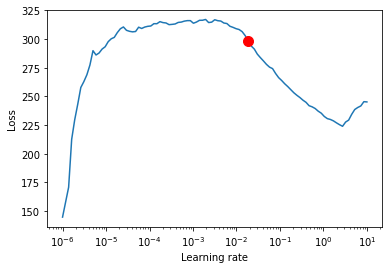

C:\Users\USER\AppData\Local\Temp/ipykernel_19480/450857479.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [33]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [34]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [35]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork      

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [36]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [37]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(264.7295)

In [39]:
pd.DataFrame(predictions)

,0,1,2,3,4,5
0,7.654758e+01,6.662767e+01,8.445963e+01,7.208760e+01,6.207937e+01,7.830190e+01
1,4.137921e+01,3.910981e+01,5.838522e+01,4.547721e+01,3.724876e+01,4.817760e+01
2,1.936855e+01,2.062547e+01,3.626199e+01,1.920479e+01,1.758471e+01,2.850496e+01
3,8.127841e+01,7.527876e+01,7.459404e+01,7.112189e+01,4.739226e+01,1.550130e+02
4,2.237522e+01,2.074800e+01,2.064070e+01,1.765466e+01,2.046249e+01,2.431676e+01
...,...,...,...,...,...,...
345,3.494163e+02,3.321322e+02,4.875268e+02,2.967838e+02,2.832310e+02,4.195291e+02
346,1.712540e+03,1.510702e+03,1.414075e+03,1.423324e+03,1.322457e+03,1.908887e+03
347,1.991555e+03,1.942330e+03,2.035182e+03,1.720855e+03,1.620290e+03,2.065558e+03
348,6.738699e+01,6.834065e+01,6.707821e+01,6.253365e+01,6.086574e+01,7.358498e+01


In [40]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [43]:
x['groups']

tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  8],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  8],
        [ 1,  9],
        [ 1, 22],
        [ 1, 24],
        [ 2,  0],
        [ 2,  1],
        [ 2,  2],
        [ 2,  3],
        [ 2,  4],
        [ 2, 23],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 4,  0],
        [ 4,  1],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4, 10],
        [ 4, 15],
        [ 4, 17],
        [ 4, 19],
        [ 5,  0],
        [ 5,  1],
        [ 5,  2],
        [ 5,  3],
        [ 5,  4],
        [ 5, 15],
        [ 6,  0],
        [ 6,  1],
        [ 6,  2],
        [ 6,  3],
        [ 6,  4],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 7,  3],
        [ 7,  4],
        [ 7, 15],
        [ 7, 20],
        [ 8,  0],
        [ 8,  1],
        [ 

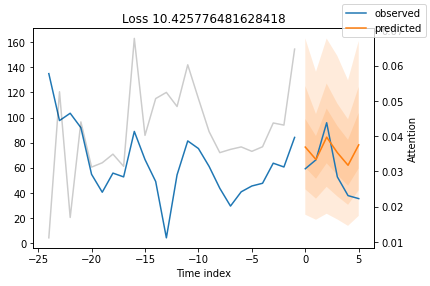

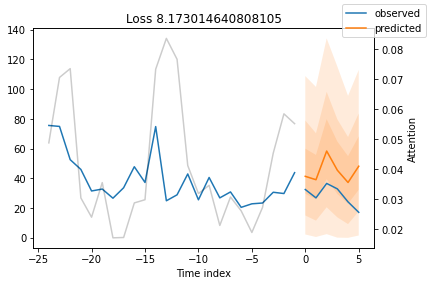

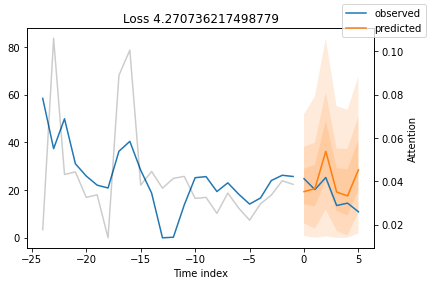

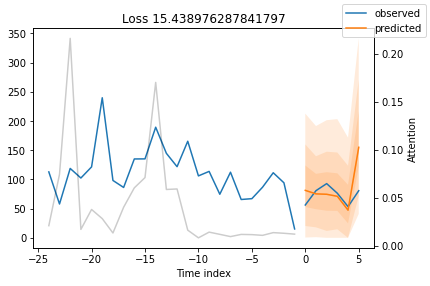

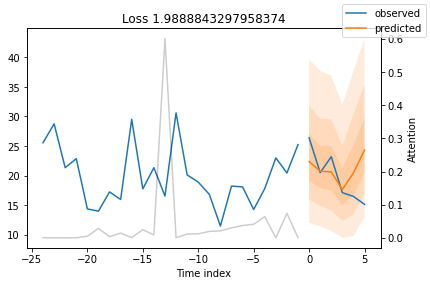

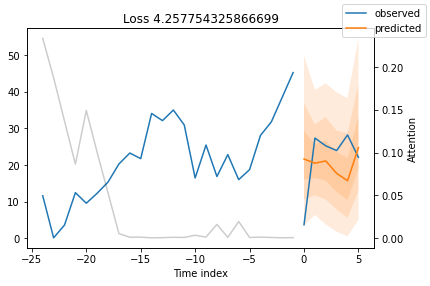

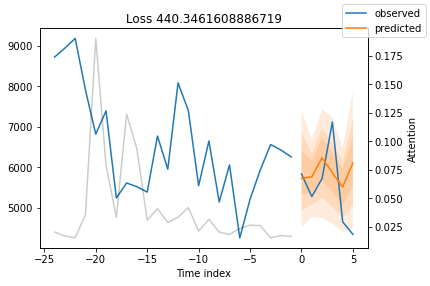

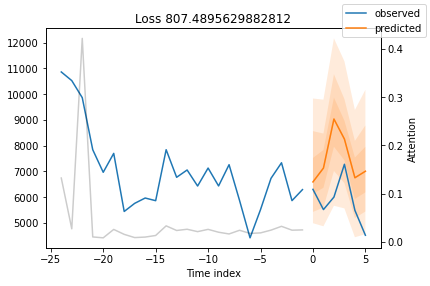

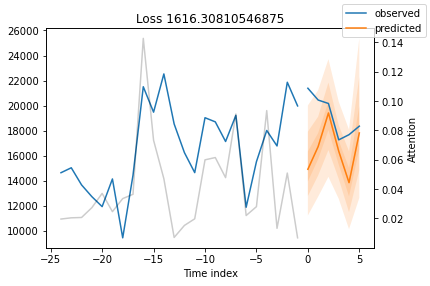

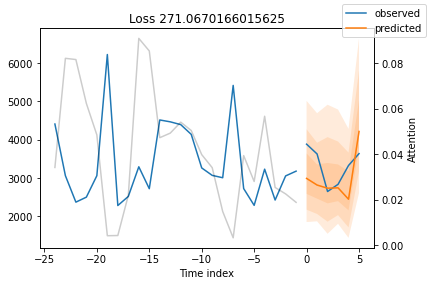

In [44]:
for idx in range(10):  # plot 10 examples
    #10개 그룹만 보기
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [45]:
#predict on new data

# select last 24 months from data (max_encoder_length is 24)
#나는 여기서 144*5 time stamp를 가져온다.
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)
#앞으로 6달 예측

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [47]:
encoder_data
#350 * 24 

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
1395,Agency_04,SKU_03,329.9400,2016-01-01,517389425,787479774,20.331481,1555.174877,1364.590954,190.583923,...,-,-,-,12.254823,215,36,1,5.798911,1305.280042,79.215120
1396,Agency_05,SKU_04,2983.4910,2016-01-01,517389425,787479774,24.405797,2135.424114,1801.804597,333.619517,...,-,-,-,15.623103,20,36,1,8.000849,942.376267,1410.060200
1394,Agency_03,SKU_05,544.0446,2016-01-01,517389425,787479774,20.331481,1627.401548,1347.982304,279.419244,...,-,-,-,17.169656,202,36,1,6.299031,1091.665142,1580.954850
1397,Agency_42,SKU_05,371.5146,2016-01-01,517389425,787479774,22.841758,1629.296555,1228.912937,400.383618,...,-,-,-,24.574017,348,36,1,5.917588,1091.665142,316.032840
1221,Agency_46,SKU_17,0.0000,2016-01-01,517389425,787479774,23.100990,0.000000,0.000000,0.000000,...,-,-,-,0.000000,321,36,1,-18.420681,0.000000,2971.672950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,59,12,2.283769,2304.827516,76.037400
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,59,12,7.712153,1530.930920,3311.367493
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,59,12,4.472130,1530.930920,56.557950
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,59,12,5.786527,2304.827516,3311.367493


In [46]:
decoder_data

#350* 6 step

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_52,SKU_02,1455.40800,2018-01-01,618073219,919709619,30.759805,1709.140347,1403.137086,306.003261,...,-,-,-,17.903928,47,60,1,7.283042,2267.730115,590.241720
1,Agency_32,SKU_05,3606.51600,2018-01-01,618073219,919709619,22.717406,1924.429706,1559.952757,364.476949,...,-,-,-,18.939478,147,60,1,8.190497,1530.930920,1863.056125
2,Agency_09,SKU_21,0.92655,2018-01-01,618073219,919709619,31.129991,2476.908694,2233.819815,243.088879,...,-,-,-,9.814204,53,60,1,-0.076287,0.354645,2434.174114
3,Agency_08,SKU_04,186.77970,2018-01-01,618073219,919709619,25.373665,2486.862499,1934.749052,552.113447,...,-,-,-,22.201205,335,60,1,5.229930,1408.486009,76.037400
4,Agency_52,SKU_05,963.10050,2018-01-01,618073219,919709619,30.759805,1890.908050,1632.868569,258.039481,...,-,-,-,13.646326,46,60,1,6.870158,1530.930920,590.241720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,Agency_08,SKU_03,9.81360,2018-06-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,65,6,2.283769,2304.827516,76.037400
2096,Agency_60,SKU_05,2235.34950,2018-06-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,65,6,7.712153,1530.930920,3311.367493
2097,Agency_19,SKU_05,87.54300,2018-06-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,65,6,4.472130,1530.930920,56.557950
2098,Agency_60,SKU_03,325.87920,2018-06-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,65,6,5.786527,2304.827516,3311.367493
